In [25]:
"""@author: Cesar Godoy Delaigue"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import STL
from pandas.plotting import register_matplotlib_converters
warnings.filterwarnings('ignore') # Para evitar los molestos avisos.
%matplotlib inline
register_matplotlib_converters()
import scipy.stats as stats
from plotnine import ggplot, aes, geom_histogram, geom_density, geom_qq, facet_wrap
from plotnine import *
import matplotlib.dates as mdates

In [26]:
# Enlace de Google Drive
view_url = 'https://docs.google.com/spreadsheets/d/1GBa3DCBHOmJTdBM1ixifaOVUg6wXt6rx/edit?usp=drive_link&ouid=103548257532735442746&rtpof=true&sd=true'

# Obtener el ID del archivo de Google Drive
file_id = view_url.split('/')[5]

# Crear la URL directa
direct_url = f"https://drive.google.com/uc?export=download&id={file_id}"

# Descargar el archivo usando gdown
output = 'Q_Medio_Mensual_output_17072024.xlsx'
gdown.download(direct_url, output, quiet=False)

# Cargar el archivo Excel con pandas
def load_excel_data(file_path: str) -> pd.DataFrame:
    """Load data from an Excel file.

    Args:
        file_path: Path to the Excel file.

    Returns:
        DataFrame containing the loaded data.
    """
    df = pd.read_excel(file_path)
    print(df)
    return df
    
    return df

# Cargar el archivo Excel descargado
df_input = load_excel_data(output)

# Mostrar el dataframe
print(df_input)


Downloading...
From: https://drive.google.com/uc?export=download&id=1GBa3DCBHOmJTdBM1ixifaOVUg6wXt6rx
To: c:\Entorno_Desarrollo_UDD\PyDataScience_ProyectoFinal\notebook\Q_Medio_Mensual_output_17072024.xlsx
100%|██████████| 1.05M/1.05M [00:00<00:00, 5.38MB/s]


         Origen      Fecha  Qmedio_mensual_l/s
0      ARPES-01 2014-01-01            6.658555
1      ARPES-01 2014-02-01            7.717431
2      ARPES-01 2014-03-01            7.663063
3      ARPES-01 2014-04-01            7.573851
4      ARPES-01 2014-05-01            5.465879
...         ...        ...                 ...
41221   XP17-05 2024-06-01            0.274481
41222   XP17-05 2024-08-01            0.070146
41223   XP17-05 2024-09-01            0.100827
41224   XP17-05 2024-10-01            0.841751
41225   XP17-05 2024-12-01            0.211238

[41226 rows x 3 columns]
         Origen      Fecha  Qmedio_mensual_l/s
0      ARPES-01 2014-01-01            6.658555
1      ARPES-01 2014-02-01            7.717431
2      ARPES-01 2014-03-01            7.663063
3      ARPES-01 2014-04-01            7.573851
4      ARPES-01 2014-05-01            5.465879
...         ...        ...                 ...
41221   XP17-05 2024-06-01            0.274481
41222   XP17-05 2024-08-01        

In [27]:
# Función para transformar el DataFrame
def transformar_dataframe(df_input):
    """
    Transforma el DataFrame de entrada:
    - Convierte la columna 'Fecha' a formato datetime.
    - Selecciona y renombra columnas específicas.

    Args:
    df_input (pd.DataFrame): DataFrame de entrada.

    Returns:
    pd.DataFrame: DataFrame transformado.
    """
    # Verificar que las columnas necesarias existen en el DataFrame
    required_columns = ['Origen', 'Fecha', 'Qmedio_mensual_l/s']
    for col in required_columns:
        if col not in df_input.columns:
            raise ValueError(f"Columna '{col}' no encontrada en el DataFrame de entrada.")
    
    # Convertir la columna 'FECHA_D' a formato datetime
    df_input['FECHA_D'] = pd.to_datetime(df_input['Fecha'])

    # Crear una copia del DataFrame con las columnas seleccionadas
    df_input = df_input[['Origen', 'Fecha', 'Qmedio_mensual_l/s']].copy()
    
    # Eliminar espacios alrededor de los nombres de columnas por si acaso
    df_input.columns = df_input.columns.str.strip()

    # Renombrar las columnas
    df_input = df_input.rename(columns={
        'Origen': 'Pozo',
        'Fecha': 'Fecha',
        'Qmedio_mensual_l/s': 'Caudal (L/s)'
    })

    # Devolver el DataFrame transformado
    return df_input

In [28]:
df_train = transformar_dataframe(df_input)
print(df_train)

           Pozo      Fecha  Caudal (L/s)
0      ARPES-01 2014-01-01      6.658555
1      ARPES-01 2014-02-01      7.717431
2      ARPES-01 2014-03-01      7.663063
3      ARPES-01 2014-04-01      7.573851
4      ARPES-01 2014-05-01      5.465879
...         ...        ...           ...
41221   XP17-05 2024-06-01      0.274481
41222   XP17-05 2024-08-01      0.070146
41223   XP17-05 2024-09-01      0.100827
41224   XP17-05 2024-10-01      0.841751
41225   XP17-05 2024-12-01      0.211238

[41226 rows x 3 columns]


hampel_filter:

Esta función aplica el filtro de Hampel a una serie temporal ts.

Secuencia:
* Inicializa variables y parámetros, incluyendo el factor de normalización k.
* Itera sobre cada punto de la serie temporal, definiendo una ventana alrededor de cada punto.
* Calcula la mediana y la mediana absoluta de las desviaciones (MAD) dentro de la ventana.
* Identifica los outliers comparando la desviación del punto respecto a la mediana con un umbral basado en n_sigmas y MAD.
* Si se detecta un outlier y imputation es True, reemplaza el valor del outlier por la mediana.
* Retorna la serie temporal filtrada y los índices de los outliers.

In [29]:
# Función para aplicar el filtro de Hampel con imputación opcional, ajustado para manejar bordes
def hampel_filter(ts, window_size, n_sigmas=2, imputation=True):
    n = len(ts)
    new_ts = ts.copy()
    k = 1.4826  # factor de normalización para la mediana absoluta de las desviaciones
    indices = []

    for i in range(n):
        start = max(0, i - window_size)
        end = min(n, i + window_size + 1)
        window = ts[start:end]
        median = np.median(window)
        diff = np.abs(window - median)
        MAD = np.median(diff)
        
        if MAD == 0:
            MAD = np.median(diff)  # Si MAD es 0, usar la mediana en su lugar

        if np.abs(ts[i] - median) > n_sigmas * k * MAD:
            if imputation:
                new_ts[i] = median  # Reemplazar outliers por la mediana
            indices.append(i)

    return new_ts, indices

apply_hampel_by_well:

Esta función aplica el filtro de Hampel a cada pozo individualmente.

Secuencia:
* Obtiene una lista de pozos únicos del DataFrame df.
* Itera sobre cada pozo, filtra los datos correspondientes a ese pozo y aplica el filtro de Hampel.
* Agrega una columna Caudal_Filtrado con los valores filtrados y una columna Outlier que marca los valores atípicos.
* Combina los resultados de todos los pozos en un solo DataFrame y lo retorna.

In [30]:
# Aplicar el filtro de Hampel por cada pozo
def apply_hampel_by_well(df, window_size=7, n_sigmas=2, imputation=True):
    unique_wells = df['Pozo'].unique()
    results = []

    for well in unique_wells:
        well_df = df[df['Pozo'] == well].copy()
        ts = well_df['Caudal (L/s)']
        ts_imputed, outlier_indices = hampel_filter(ts, window_size, n_sigmas, imputation)
        
        well_df['Caudal_Filtrado'] = ts_imputed
        well_df['Outlier'] = False
        well_df.loc[well_df.index[outlier_indices], 'Outlier'] = True
        
        results.append(well_df)
    
    combined_df = pd.concat(results)
    return combined_df

In [31]:
# Convertir la columna 'Fecha' a tipo datetime y establecerla como índice
df_train['Fecha'] = pd.to_datetime(df_train['Fecha'])
df_train.set_index('Fecha', inplace=True)

# Aplicar el filtro y obtener el DataFrame combinado
result_df = apply_hampel_by_well(df_train)

# Guardar el resultado en un archivo CSV para verificación
result_df.to_excel('resultados_filtrados.xlsx')

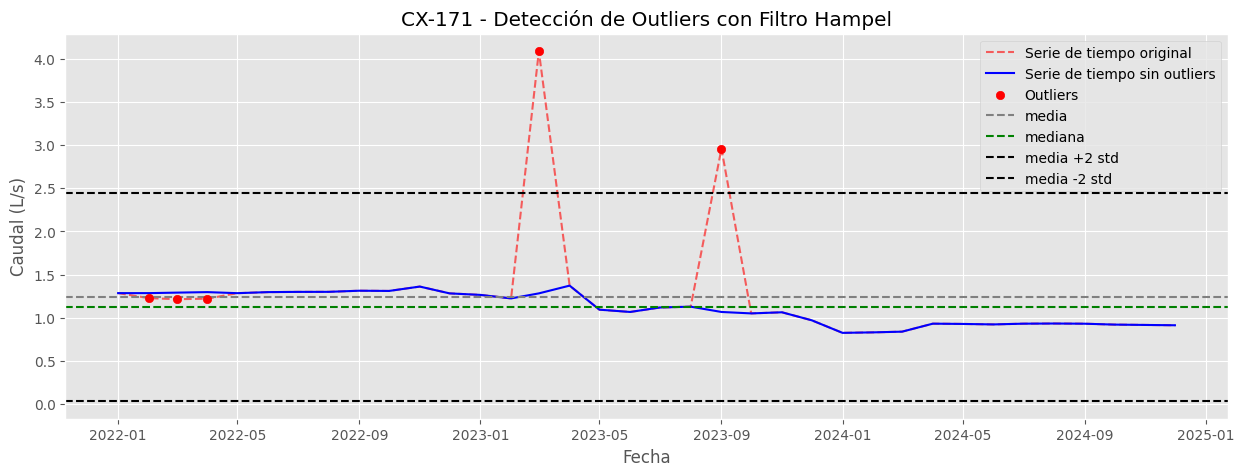

In [32]:
plt.style.use('ggplot')

# Visualizar los resultados para un pozo específico
well_name = 'CX-171'
if well_name in result_df['Pozo'].unique():
    well_df = result_df[result_df['Pozo'] == well_name]
    ts = well_df['Caudal (L/s)']
    ts_imputation = well_df['Caudal_Filtrado']
    outliers = well_df[well_df['Outlier'] == True]['Caudal (L/s)']

    # Calcular estadísticas
    mean = ts.mean()
    median = ts.median()
    std = ts.std()

    # Graficar los resultados
    plt.figure(figsize=(15, 5))  # Tamaño ajustado para mejor visualización

    # Graficar la serie de tiempo original con outliers
    plt.plot(ts.index, ts, 'r--', label='Serie de tiempo original', alpha=0.6)

    # Graficar la serie sin outliers segmentada y en azul (incluyendo valores imputados)
    plt.plot(ts.index, ts_imputation, 'b-', label='Serie de tiempo sin outliers')

    # Destacar los puntos outliers
    plt.scatter(outliers.index, outliers, color='red', label='Outliers', zorder=5)

    # Líneas de media y desviaciones estándar
    plt.axhline(y=mean, color='gray', linestyle='--', label='media')
    plt.axhline(y=median, color='green', linestyle='--', label='mediana')
    plt.axhline(y=mean + 2 * std, color='k', linestyle='--', label='media +2 std')
    plt.axhline(y=mean - 2 * std, color='k', linestyle='--', label='media -2 std')

    # Ajustar los ejes automáticamente
    plt.autoscale()

    # Añadir etiquetas y título
    plt.xlabel('Fecha')
    plt.ylabel('Caudal (L/s)')
    plt.title(f'{well_name} - Detección de Outliers con Filtro Hampel')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No se encontraron datos para el pozo {well_name}")

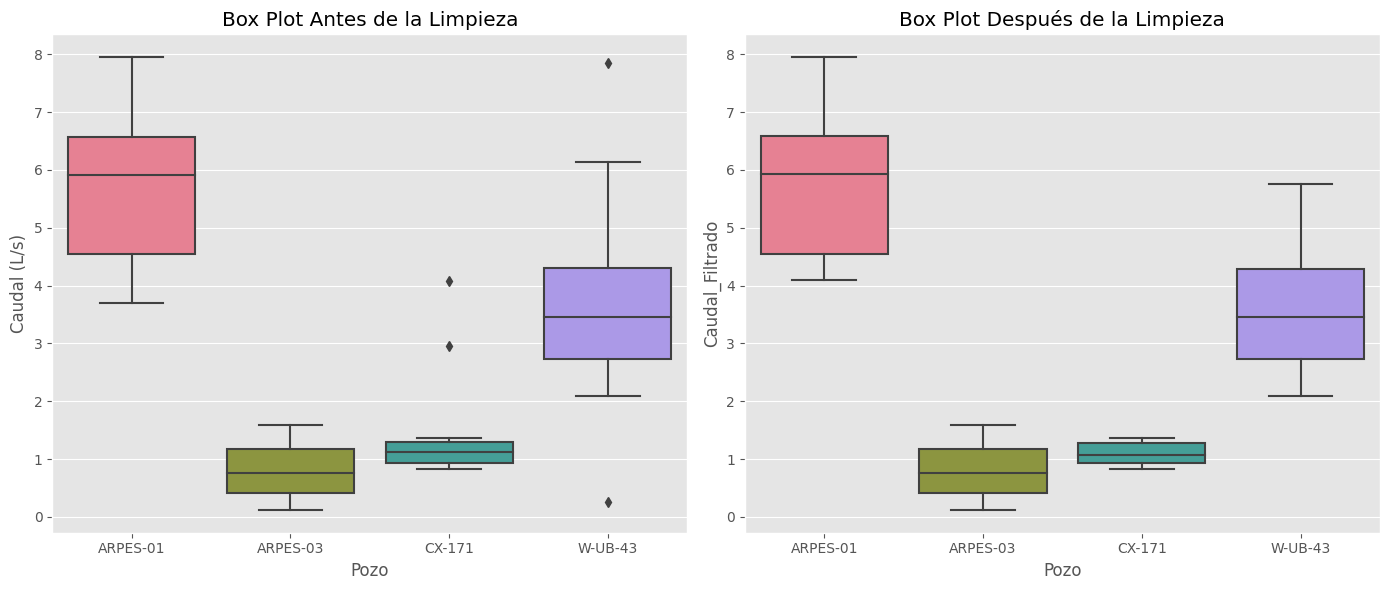

In [34]:
# Generar los box plots
plt.style.use('ggplot')

# Lista de pozos
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'W-UB-43']

# Generar la figura
plt.figure(figsize=(14, 6))

# Definir una paleta de colores
palette = sns.color_palette("husl", len(pozos))

# Box Plot antes de la limpieza
plt.subplot(1, 2, 1)
sns.boxplot(x='Pozo', y='Caudal (L/s)', data=result_df[result_df['Pozo'].isin(pozos)], palette=palette)
plt.title('Box Plot Antes de la Limpieza')

# Box Plot después de la limpieza
df_no_outliers_result = result_df[result_df['Outlier'] == False]
plt.subplot(1, 2, 2)
sns.boxplot(x='Pozo', y='Caudal_Filtrado', data=df_no_outliers_result[df_no_outliers_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Box Plot Después de la Limpieza')

# Mostrar los Box Plots
plt.tight_layout()
plt.show()

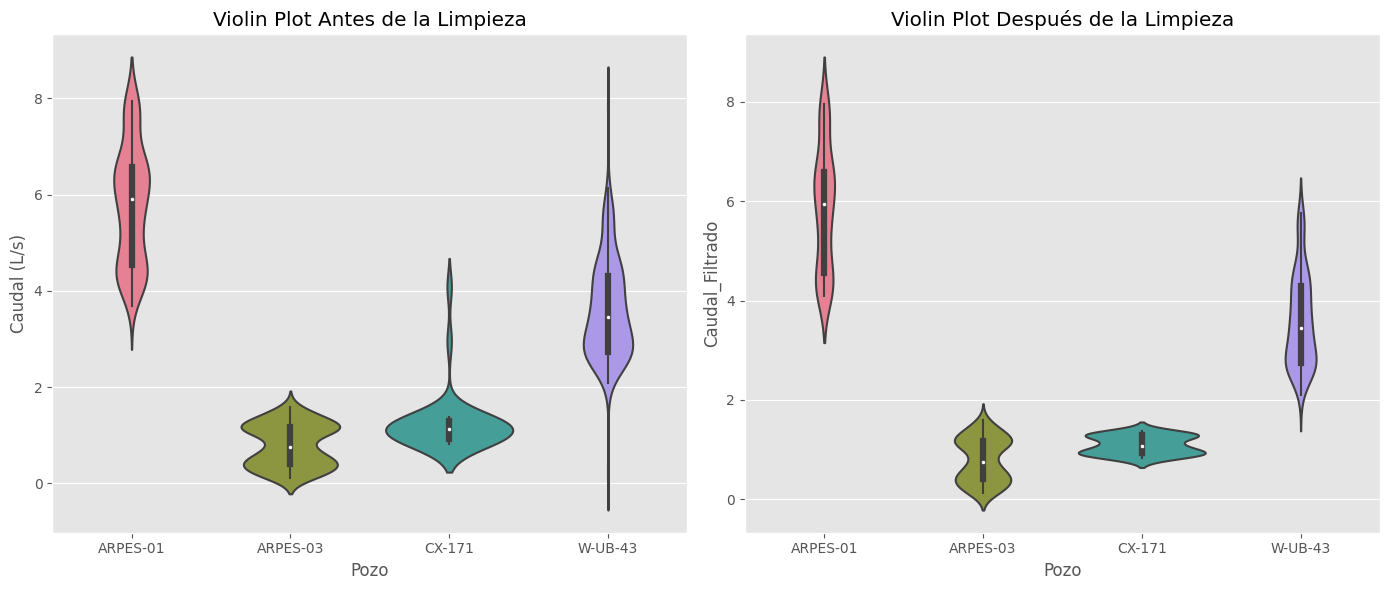

In [35]:
# Generar los violin plots
plt.style.use('ggplot')

# Lista de pozos
pozos = ['ARPES-01', 'ARPES-03', 'CX-171', 'W-UB-43']

# Generar la figura
plt.figure(figsize=(14, 6))

# Definir una paleta de colores
palette = sns.color_palette("husl", len(pozos))

# Violin Plot antes de la limpieza
plt.subplot(1, 2, 1)
sns.violinplot(x='Pozo', y='Caudal (L/s)', data=result_df[result_df['Pozo'].isin(pozos)], palette=palette)
plt.title('Violin Plot Antes de la Limpieza')

# Violin Plot después de la limpieza
df_no_outliers_result = result_df[result_df['Outlier'] == False]
plt.subplot(1, 2, 2)
sns.violinplot(x='Pozo', y='Caudal_Filtrado', data=df_no_outliers_result[df_no_outliers_result['Pozo'].isin(pozos)], palette=palette)
plt.title('Violin Plot Después de la Limpieza')

# Mostrar los Violin Plots
plt.tight_layout()
plt.show()